<a href="https://colab.research.google.com/github/MarinaWolters/Coding-Tracker/blob/master/HandsOn9_AssessingMLModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessing and Building Better ML Models

In this notebook, we will use a language dataset to learn more about assessing machine learning models and tuning them. Specifically, we will cover:
- Which metrics to use to evaluate classifier performance?
- How to deal with missing data?
- How to handle class imbalance?
- How to pick the optimal parameters for training a model?

Unlike the datasets we used in prior notebooks, this dataset is hard(er) to model (so brace yourself for lower performance numbers). 

**Install required libraries (if missing)**

In [ ]:
#!pip install pandas
#!pip install sklearn
#!pip install seaborn
#!pip install --upgrade xlrd

**Import the required libraries**

In [ ]:
# import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import random
import matplotlib.pyplot as plt
from scipy.stats import loguniform
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, validation_curve, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#Disable warnings (Not a good idea in general, but helps clean output for today)
import warnings
warnings.filterwarnings('ignore')

# Dataset

We will use a dataset that has been derived from blog posts of individuals collected by J. Schler, M. Koppel, S. Argamon and J. Pennebaker for their work in [this paper](http://u.cs.biu.ac.il/~schlerj/schler_springsymp06.pdf) published in 2006. 

The users shared their blog posts along with their age, gender, and occupation. This subset contains all posts from a random set of 1000 users and has been shared [online](https://dlatk.wwbp.org/datasets.html#language-data) with permission from Moshe Koppel.

We will start with the 1grams derived from the blogposts for each user and not extract them in this notebook. However, feel free to explore the raw text dataset to extract different features. Here is an example of the original dataframe: 
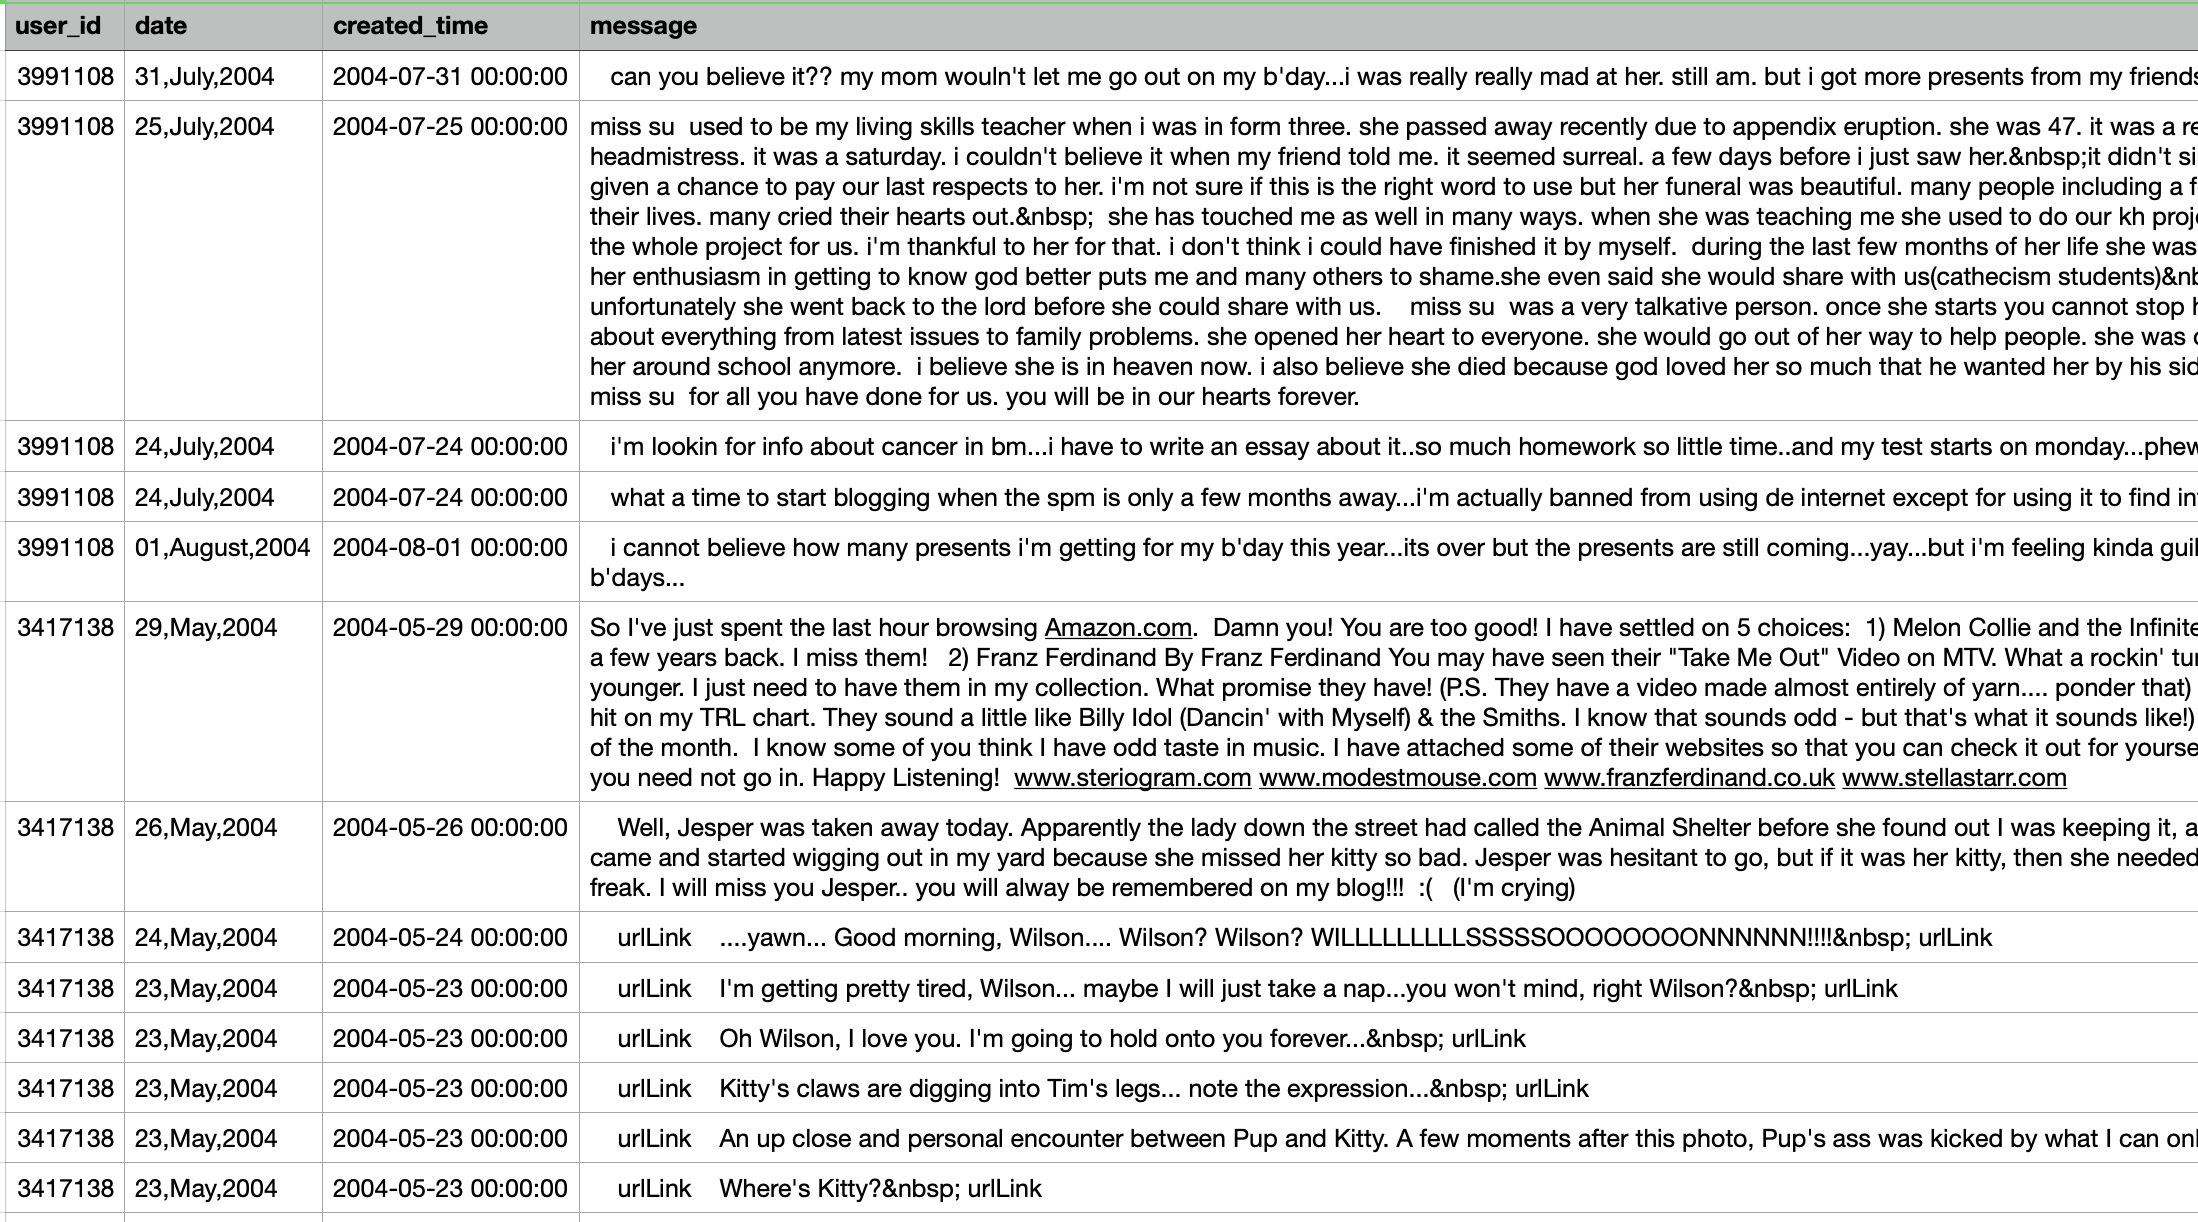 


We will download the feature file (1-grams) along with the attributes (age, gender, occupation, star sign) file for about 1000 users. 

The 1gram table looks like this (group_id corresponds to the user_id in the attributes file):

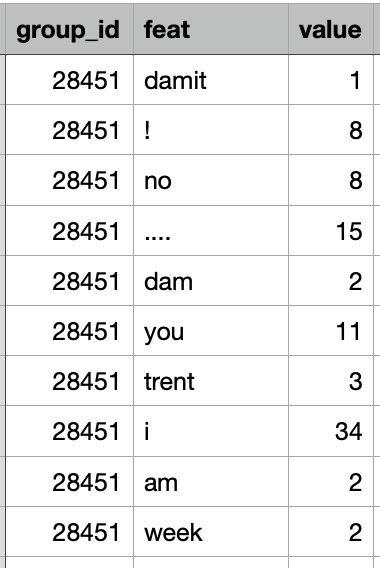

**Question**: How many unique 1grams do you think the dataset will have? 

In [ ]:
# Loading the data
# labels_url = "https://storage.googleapis.com/penn-cis5450/blog_outcomes.csv"
# User Attributes 
labels_url = 'https://raw.githubusercontent.com/chandrasg/CIS5450_Summer22/main/blog_outcomes.csv'
labels_df = pd.read_csv(labels_url, engine='python')

# 1-gram feature file grom Google Drive
feat_url = 'https://drive.google.com/file/d/15ga1IC6Y_xJRf765ar9vC_FohExtCiOn/view?usp=sharing'
feat_url = 'https://drive.google.com/uc?id=' + feat_url.split('/')[-2]
feat_df = pd.read_csv(feat_url, engine='python', encoding ='latin1')


In [ ]:
labels_df.head()

,user_id,gender,age,occu,sign,is_indunk,is_student,is_education,is_technology
0,3991108,1,17,indUnk,Leo,1,NaN,NaN,NaN
1,3417138,1,25,Communications-Media,Taurus,0,0.0,NaN,NaN
2,3673414,0,14,Student,Scorpio,0,1.0,NaN,NaN
3,3361075,1,16,Student,Capricorn,0,1.0,NaN,NaN
4,4115327,1,14,indUnk,Libra,1,NaN,NaN,NaN


In [ ]:
feat_df.head()

,id,group_id,feat,value,group_norm
0,1.0,28451,damit,1,0.000953
1,2.0,28451,!,8,0.007626
2,3.0,28451,no,8,0.007626
3,4.0,28451,....,15,0.014299
4,5.0,28451,dam,2,0.001907


In [ ]:
# [TODO] Look at the attributes df

feat_df.isnull().sum()

id             0
group_id       0
feat          20
value          0
group_norm     0
dtype: int64

In [ ]:
len(feat_df) -len(feat_df.drop_duplicates(['group_id', 'feat']))

30

In [ ]:
feat_df = feat_df.dropna(subset=['feat'])
feat_df = feat_df.drop_duplicates(['group_id','feat'])

In [ ]:

labels_df

,user_id,gender,age,occu,sign,is_indunk,is_student,is_education,is_technology
0,3991108,1,17,indUnk,Leo,1,NaN,NaN,NaN
1,3417138,1,25,Communications-Media,Taurus,0,0.0,NaN,NaN
2,3673414,0,14,Student,Scorpio,0,1.0,NaN,NaN
3,3361075,1,16,Student,Capricorn,0,1.0,NaN,NaN
4,4115327,1,14,indUnk,Libra,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
995,2542729,0,26,Technology,Scorpio,0,0.0,NaN,NaN
996,3840766,1,48,indUnk,Libra,1,NaN,NaN,NaN
997,4043476,0,15,Student,Cancer,0,1.0,NaN,NaN
998,3348721,0,26,Technology,Libra,0,0.0,NaN,NaN


In [ ]:
feat_df

,id,group_id,feat,value,group_norm
0,1.0,28451,damit,1,0.000953
1,2.0,28451,!,8,0.007626
2,3.0,28451,no,8,0.007626
3,4.0,28451,....,15,0.014299
4,5.0,28451,dam,2,0.001907
...,...,...,...,...,...
1264189,1264190.0,4325889,success,1,0.000554
1264190,1264191.0,4325889,quests,1,0.000554
1264191,1264192.0,4325889,venture,1,0.000554
1264192,1264193.0,4325889,kingdom,1,0.000554


This df looks different - almost similar to a sparse representation. 

**Question** - What is the advantage of this representation?

We want to convert long dataframe to wide for further analyses. 

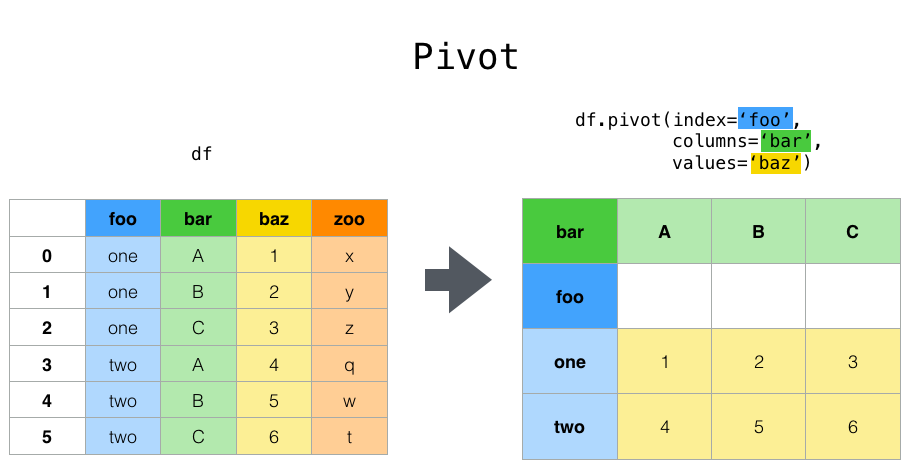

https://pandas.pydata.org/pandas-docs/version/0.23.4/reshaping.html

In [ ]:
# [TODO] Convert long dataframe to a wide
feat_wide = pd.pivot(feat_df, index = 'group_id', columns = 'feat', values = 'value' )
feat_wide.reset_index(inplace = True)

In [ ]:
# Look at the wide dataframe
feat_wide

feat,group_id,,!,"""",""">",""">>",""">>>>>>>>",#,####burn,#000000,...,ÿæÿå,ÿæµ,ÿç,ÿç,ÿè,ÿè½æ,ÿè,ÿé,ÿï¼,ÿï¼
0,28451,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,174357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,216833,NaN,304.0,224.0,NaN,NaN,NaN,8.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,317581,NaN,379.0,577.0,NaN,NaN,NaN,11.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,446275,NaN,11.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4313487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,4320505,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,4321513,NaN,10.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,4325536,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Now let's look the attributes df

labels_df

,user_id,gender,age,occu,sign,is_indunk,is_student,is_education,is_technology
0,3991108,1,17,indUnk,Leo,1,NaN,NaN,NaN
1,3417138,1,25,Communications-Media,Taurus,0,0.0,NaN,NaN
2,3673414,0,14,Student,Scorpio,0,1.0,NaN,NaN
3,3361075,1,16,Student,Capricorn,0,1.0,NaN,NaN
4,4115327,1,14,indUnk,Libra,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
995,2542729,0,26,Technology,Scorpio,0,0.0,NaN,NaN
996,3840766,1,48,indUnk,Libra,1,NaN,NaN,NaN
997,4043476,0,15,Student,Cancer,0,1.0,NaN,NaN
998,3348721,0,26,Technology,Libra,0,0.0,NaN,NaN


Looking at the attributes file and the feature file, the keys do not seem to be aligned. 

**Question**: How do we align the group_id and user_id columns so that they can be converted into feature (_X_) and label vectors (_y_) to be passed as input and output to the machine learning model?

In [ ]:
# [TODO] Merge the dataframes
feat_outcomes = pd.merge(feat_wide, labels_df, left_on='group_id', right_on = 'user_id')
feat_outcomes

,group_id,,!,"""",""">",""">>",""">>>>>>>>",#,####burn,#000000,...,ÿï¼,user_id,gender_y,age_y,occu,sign_y,is_indunk,is_student,is_education,is_technology
0,28451,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,28451,0,27,Internet,Aquarius,0,0.0,NaN,NaN
1,174357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,174357,1,23,indUnk,Aquarius,1,NaN,NaN,NaN
2,216833,NaN,304.0,224.0,NaN,NaN,NaN,8.0,NaN,NaN,...,NaN,216833,0,24,Student,Scorpio,0,1.0,NaN,NaN
3,317581,NaN,379.0,577.0,NaN,NaN,NaN,11.0,NaN,NaN,...,NaN,317581,0,26,Technology,Scorpio,0,0.0,NaN,NaN
4,446275,NaN,11.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,446275,1,17,indUnk,Virgo,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4313487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4313487,0,26,indUnk,Sagittarius,1,NaN,NaN,NaN
996,4320505,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4320505,1,33,indUnk,Sagittarius,1,NaN,NaN,NaN
997,4321513,NaN,10.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4321513,0,16,Student,Taurus,0,1.0,NaN,NaN
998,4325536,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4325536,1,25,indUnk,Leo,1,NaN,NaN,NaN


# Classification Task 1: Predict Gender based on words used in the blog posts 

In [ ]:
# Creating class label df
y = feat_outcomes[['gender_y']]
# Creating feature df
X = feat_outcomes.drop(['user_id', 'gender_y', 'age_y', 'occu', 'sign_y', 'is_indunk', 
                        'is_student', 'is_education', 'group_id', 'is_technology'], axis=1)

In [ ]:
# [TODO] Let's examine the class distribution
y.value_counts()

gender_y
0           502
1           498
dtype: int64

In [ ]:
X

,,!,"""",""">",""">>",""">>>>>>>>",#,####burn,#000000,#0000cd,...,ÿæÿå,ÿæµ,ÿç,ÿç,ÿè,ÿè½æ,ÿè,ÿé,ÿï¼,ÿï¼
0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,304.0,224.0,NaN,NaN,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,379.0,577.0,NaN,NaN,NaN,11.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,11.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,NaN,10.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The feature matrix has a lot of missing values. 

**Question** How do we handle missing values in this case? Note that these are words written in each user's blogposts

In [ ]:
# [TODO] Handle Missing Values
X.fillna(0, inplace=True)

In [ ]:
X

,,!,"""",""">",""">>",""">>>>>>>>",#,####burn,#000000,#0000cd,...,ÿæÿå,ÿæµ,ÿç,ÿç,ÿè,ÿè½æ,ÿè,ÿé,ÿï¼,ÿï¼
0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,304.0,224.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,379.0,577.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,11.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,10.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Question**: Now that we have the feature matrix and the label vector, what are the next steps in the classification pipeline?

In [ ]:
# Splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40, random_state=10)

In [ ]:
# [TODO] Do we need to address the dimensionality of the feature matrix?

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=0)
# Scaling for PCA: Two options in this case! 

## 1. Standard Scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 2. Divide by the total number of words present in each user's blogposts
#X_scaled_div_by_sum = X....


In [ ]:
X_train

In [ ]:
# [TODO] Apply PCA
# let's choose 100 PCs even though they may not capture 95% variance 
# to keep the data size manageable for this notebook
num_pcs = 100
pca = PCA(n_components = num_pcs)

# fit on training data
pca.fit(X_train)

# and transform training and testing data
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
# [TODO] Build a logistic regression model with no penalty and saga solver
clf_ridge = LogisticRegression(penalty='none',solver='saga').fit(X_train_pca, y_train)

# storing predicted values
predictions_ridge = clf_ridge.predict(X_test_pca)

# [TODO] Measure performance metrics of the model - accuracy, precision, recall, and AUC
print("No Penalty Logistic: ", 
      'Accuracy: ', accuracy_score(y_test, predictions_ridge), 
      ' Recall: ', format(recall_score(y_test, predictions_ridge),'.2f'), 
      ' Precision: ', format(precision_score(y_test, predictions_ridge),'.2f'), 
      ' AUC: ', format(roc_auc_score(y_test, clf_ridge.predict_proba(X_test_pca)[:,1]),'.2f'))

# Note the inputs to the roc_auc_score function

No Penalty Logistic:  Accuracy:  0.5975  Recall:  0.90  Precision:  0.56  AUC:  0.76


Let's look at the different metrics on the test set:

**Questions**
- Is this a good accuracy? 
- What does the recall and precision values signify?
- How do we interpret the AUC? 

**Question** What are the steps in identifying optimal parameters of the model? 

In [ ]:
## Let's tune the L2 regularization parameter (C) and examine the difference in L1 vs L2 reg, and test two solvers: liblinear and lbfgs!
clf_ridge = LogisticRegression(random_state=10)

# [TODO] Define the parameter space. Note that we could also vary other parameters such as 
### penalty to be L1, L2, ElasticNet; 
### solver to be saga, liblinear, ...;
### These parameters will vary with the algorithm we choose: RFC, Logistic, .. 
search_space = dict()
search_space['C'] = [0.00001, 0.0001, 0.01, 1]
search_space['solver'] = ['liblinear', 'lbfgs']
search_space['penalty'] = ['l1', 'l2']

# initiating Randomized Search Cross Validation; Similar to GridSearch but faster 
clf = RandomizedSearchCV(clf_ridge, search_space, n_iter=200, n_jobs=-1, cv=5, random_state=10)

search_cv = clf.fit(X_train_pca, y_train)

columns = [f"param_{name}" for name in search_space.keys()]
columns += ["mean_test_error", "std_test_error"]
cv_results = pd.DataFrame(search_cv.cv_results_)
#print(cv_results)
cv_results["mean_test_error"] = cv_results["mean_test_score"]
cv_results["std_test_error"] = cv_results["std_test_score"]
cv_results[columns].sort_values(by="mean_test_error")

,param_C,param_solver,param_penalty,mean_test_error,std_test_error
0,0.00001,liblinear,l1,0.508333,0.000000
4,0.0001,liblinear,l1,0.508333,0.000000
8,0.01,liblinear,l1,0.560000,0.014337
2,0.00001,liblinear,l2,0.561667,0.023921
6,0.0001,liblinear,l2,0.563333,0.023333
7,0.0001,lbfgs,l2,0.583333,0.034960
3,0.00001,lbfgs,l2,0.586667,0.033993
11,0.01,lbfgs,l2,0.678333,0.037859
10,0.01,liblinear,l2,0.678333,0.038224
15,1,lbfgs,l2,0.681667,0.045154


In [ ]:
# [TODO] Obtain the best parameters from the search object

print('Best Hyperparameters:')
print('C %s ' % search_cv.best_params_['C'])
print('solver %s' % search_cv.best_params_['solver'])
print('penalty %s' % search_cv.best_params_['penalty'])

Best Hyperparameters:
C 1 
solver liblinear
penalty l1


In [ ]:
# [TODO] Train model with the best hyperparameters
clf_ridge = LogisticRegression(penalty=search_cv.best_params_['penalty'], 
                               solver=search_cv.best_params_['solver'], 
                               C=search_cv.best_params_['C']).fit(X_train_pca, y_train)

# storing predicted values
predictions_ridge = clf_ridge.predict(X_test_pca)

# Measuring the accuracy of our model
print("Ridge: ", 'Accuracy: ', 
      accuracy_score(y_test, predictions_ridge), 
      ' Recall: ', format(recall_score(y_test, predictions_ridge),'.2f'), 
      ' Precision: ', format(precision_score(y_test, predictions_ridge),'.2f'), 
      ' AUC: ', format(roc_auc_score(y_test, clf_ridge.predict_proba(X_test_pca)[:,1]),'.2f'))

Ridge:  Accuracy:  0.6975  Recall:  0.71  Precision:  0.70  AUC:  0.74


Is there any improvment in performance from our previous model? 



Now let's look at how number of samples used for training and the regularization parameter affect training and cross validation scores?

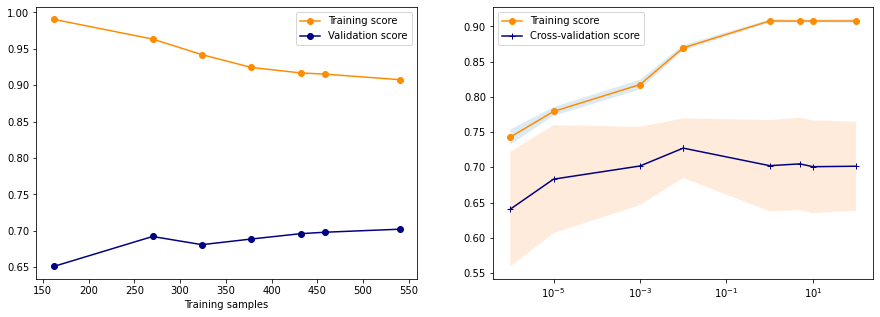

In [ ]:
## [TODO] Plot learning curve and validation curve and examine the change as number of samples go up and as CV parameters change 

X = X_train_pca
y_gender = np.array(y_train)

indices = np.arange(y_gender.shape[0])
np.random.shuffle(indices)
X = X[indices]
y_gender = y_gender[indices]

# Initializing plots for learning and validation curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Learning curve
clf = LogisticRegression(random_state=10).fit(X_train_pca, y_gender)
train_sizes_lc, train_scores_lc, test_scores_lc = learning_curve(clf, X, y_gender, 
                                                                 train_sizes=[0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 1], 
                                                                 cv=10, 
                                                                 scoring="roc_auc")

#[TODO] Plot the train and validation scores
ax1.plot(train_sizes_lc, np.mean(train_scores_lc, axis=1), color='darkorange', label="Training score", marker='o')
ax1.plot(train_sizes_lc, np.mean(test_scores_lc, axis=1), color='navy', label="Validation score", marker='o')
ax1.set_xlabel('Training samples')
ax1.legend(loc="best")

# Validation curve
param_range_cv = [.000001, .00001, 0.001, 0.01, 0.01, 1.0, 5.0, 10.0, 100.0]
train_scores_cv, test_scores_cv = validation_curve(clf, X, y_gender, 
                                                   param_name='C', 
                                                   param_range=param_range_cv, 
                                                   cv=10, 
                                                   scoring="roc_auc")

train_mean_cv = np.mean(train_scores_cv, axis=1)
train_std_cv = np.std(train_scores_cv, axis=1)
test_mean_cv = np.mean(test_scores_cv, axis=1)
test_std_cv = np.std(test_scores_cv, axis=1)

ax2.plot(param_range_cv, train_mean_cv, label="Training score", marker='o', markersize=6, color="darkorange")
ax2.fill_between(param_range_cv, train_mean_cv + train_std_cv, train_mean_cv - train_std_cv, alpha=0.15)
ax2.plot(param_range_cv, test_mean_cv, label="Cross-validation score", marker='+', markersize=6, color="navy")
ax2.fill_between(param_range_cv, test_mean_cv + test_std_cv, test_mean_cv - test_std_cv, alpha=0.15)
ax2.set_xscale('log')
ax2.legend(loc="best")

# Classification Task 2: Predict Occupation

What if we wanted to predict occupations? Let's look at the distribution of occupations in our data.

In [ ]:
#[TODO] Examine the distribution of occupations
y = feat_outcomes[['occu']]
y.value_counts()

#indUnk is Industry Unknown

occu                   
indUnk                     358
Student                    275
Technology                  52
Education                   50
Arts                        32
Communications-Media        27
Internet                    24
Government                  16
Non-Profit                  14
Consulting                  14
Science                     11
Religion                    11
Marketing                   10
Telecommunications          10
Manufacturing                9
Law                          9
Engineering                  9
Banking                      8
HumanResources               6
Advertising                  6
Fashion                      5
Military                     5
BusinessServices             4
Transportation               4
Sports-Recreation            4
Architecture                 3
LawEnforcement-Security      3
Construction                 3
Publishing                   3
RealEstate                   3
Tourism                      2
Biotech        

For the sake of this notebook, let's pick the top 2 classes: Unkown and Technology

In [ ]:
# [TODO] Subset y and X to contain only users whose occupation is indUnk and Technology

y = feat_outcomes.loc[(feat_outcomes.occu=='indUnk') | (feat_outcomes.occu=='Technology')][['occu']]
y = np.where(y['occu'] == 'Technology', 1, 0)

In [ ]:
X = feat_outcomes.loc[(feat_outcomes.occu=='indUnk')|(feat_outcomes.occu=='Technology')].drop(['user_id', 'gender_y', 'age_y', 'occu', 'sign_y', 'is_indunk', 
                        'is_student', 'is_education', '', 'group_id', 'is_technology'], axis=1)

Now let's run the entire model training pipeline. 

**Question**: What is the correct order of operations noted below? 

*   Scaling
*   Train/Test Split
*   Handling missing values
*   Dimensionality reduction
*   Parameter Tuning
*   Training the best model
*   Evaluating the model





In [ ]:
## Running the entire classification pipeline: 

# Handle Missing Values
X.fillna(0,inplace=True)
# Splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state = 5)
# Standard Scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Apply PCA
num_pcs = 100
pca = PCA(n_components=num_pcs)
# fit on training data
pca.fit(X_train)
# and transform training and testing data
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Tuning Parameters
clf_ridge = LogisticRegression(random_state=10)

# Defining the parameter space. 
space = dict()
space['C'] = [0.000001, .0001, .01, 1]
space['solver'] = ['liblinear', 'lbfgs']
space['penalty'] = ['l1', 'l2']

# initiating Randomized Search Cross Validation; Similar to GridSearch but faster 
clf = RandomizedSearchCV(clf_ridge, space, n_iter=200, n_jobs=-1, cv=5, random_state=10)
search = clf.fit(X_train_pca, y_train)
columns = [f"param_{name}" for name in space.keys()]
columns += ["mean_test_error", "std_test_error"]
cv_results = pd.DataFrame(search.cv_results_)
cv_results["mean_test_error"] = cv_results["mean_test_score"]
cv_results["std_test_error"] = cv_results["std_test_score"]

# Training best model
clf_ridge = LogisticRegression(penalty=search.best_params_['penalty'],solver=search.best_params_['solver'], C=search.best_params_['C']).fit(X_train_pca, y_train)
# storing predicted values
predictions_ridge = clf_ridge.predict(X_test_pca)


In [ ]:
# Measuring the accuracy of our model
print("Ridge: ", 
      'Accuracy: ', accuracy_score(y_test, predictions_ridge), 
      ' Recall: ', format(recall_score(y_test, predictions_ridge),'.2f'), 
      ' Precision: ', format(precision_score(y_test, predictions_ridge),'.2f'), 
      'AUC: ', format(roc_auc_score(y_test, clf_ridge.predict_proba(X_test_pca)[:,1]),'.2f'))


Ridge:  Accuracy:  0.8536585365853658  Recall:  0.00  Precision:  0.00 AUC:  0.50


In [ ]:
plt.figure(figsize=(8,8)).clf()

fpr_im, tpr_im, thresholds = metrics.roc_curve(y_test, clf_ridge.predict_proba(X_test_pca)[:,1])
roc_auc_im = roc_auc_score(y_test, clf_ridge.predict_proba(X_test_pca)[:,1])
plt.plot(fpr_im,tpr_im,label="imbalance not addressed, auc="+str(format(roc_auc_im,'.2f')), color='orange')

plt.plot([0, 1], ls="--", label='Random',color='black')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='best')

**Question** What do the performance metrics suggest?

Let's look at how the model is doing in terms of false positives and false negatives.

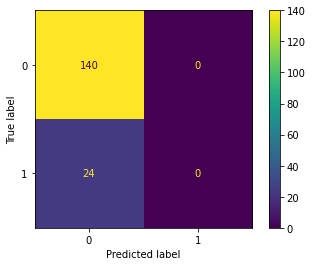

In [ ]:
# [TODO] Confusion matrix
cm = confusion_matrix(y_test, predictions_ridge, labels = clf_ridge.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=clf_ridge.classes_
                              )
disp.plot()
plt.show()

*Question* What is the model 'learning' in this case? 

Let's say the class distribution was flipped, then our metrics would be as follows:



In [ ]:
print("Ridge: ", 'Accuracy: ', 
      accuracy_score(y_test, predictions_ridge), 
      ' Recall: ', format(recall_score(y_test, predictions_ridge,pos_label='indUnk'),'.2f'), 
      ' Precision: ', format(precision_score(y_test, predictions_ridge,pos_label='indUnk'),'.2f'), 
      'AUC: ', format(roc_auc_score(y_test, clf_ridge.predict_proba(X_test_pca)[:,1]),'.2f'))

Hence the need to check AUC! 

*Question* What are the ways to handle class imbalance?

In [ ]:
# [TODO] Check LogisticRegression Documentation to identify the parameter to specify class balance
clf_ridge_balance = LogisticRegression(class_weight="balanced", random_state=10).fit(X_train_pca, y_train)

# storing predicted values
predictions_ridge_balance = clf_ridge_balance.predict(X_test_pca)
# Measuring the accuracy of our model

print("Ridge: ", 
      'Accuracy: ', accuracy_score(y_test, predictions_ridge_balance), 
      ' Recall: ', format(recall_score(y_test, predictions_ridge_balance),'.2f'), 
      ' Precision: ', format(precision_score(y_test, predictions_ridge_balance),'.2f'), 
      'AUC: ', format(roc_auc_score(y_test, clf_ridge_balance.predict_proba(X_test_pca)[:,1]),'.2f'))


Ridge:  Accuracy:  0.8170731707317073  Recall:  0.62  Precision:  0.42 AUC:  0.72


Note that we used the default parameters; if we were to tune the parameters, `class_weight` would have to be passed even for the CV part. 

Let's look at the ROC curve for both models: where imbalance was 1) not addressed, and 2) addressed

**Question** What does the ROC curve show?

0.5 0.7160714285714287


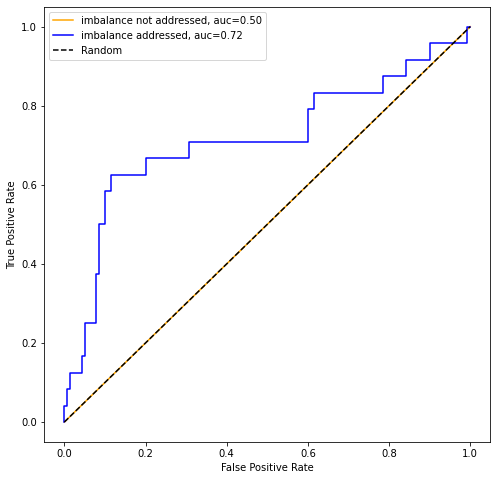

In [ ]:
# Plot the ROC curve for both models
plt.figure(figsize=(8,8)).clf()

fpr_im, tpr_im, thresholds = metrics.roc_curve(y_test, clf_ridge.predict_proba(X_test_pca)[:,1])
roc_auc_im = roc_auc_score(y_test, clf_ridge.predict_proba(X_test_pca)[:,1])
plt.plot(fpr_im,tpr_im,label="imbalance not addressed, auc="+str(format(roc_auc_im,'.2f')), color='orange')

fpr_b, tpr_b, thresholds = metrics.roc_curve(y_test, clf_ridge_balance.predict_proba(X_test_pca)[:,1])
roc_auc_b = roc_auc_score(y_test, clf_ridge_balance.predict_proba(X_test_pca)[:,1])
plt.plot(fpr_b,tpr_b,label="imbalance addressed, auc="+str(format(roc_auc_b,'.2f')), color='blue')

plt.plot([0, 1], ls="--", label='Random',color='black')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='best')

print(str(roc_auc_im) + ' ' + str(roc_auc_b))

What can we infer from this ROC Curve?

Compare this with the curve we got for Gender prediction

In [ ]:
## Run the entire classification pipeline (but this time with default parameters!)

y = feat_outcomes[['gender_y']]
y.value_counts()
X = feat_outcomes.drop(['user_id', 'gender_y', 'age_y', 'occu', 'sign_y', 'is_indunk', 
                        'is_student', 'is_education', '', 'group_id', 'is_technology'], axis=1)
# Handle Missing Values
X.fillna(0,inplace=True)
# Standard Scaler
scaler = StandardScaler()
X_scaled_std = scaler.fit_transform(X)
# Splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_scaled_std, y, test_size=0.40, random_state = 5)
# Apply PCA
num_pcs = 100
pca = PCA(n_components=num_pcs)
# fit on training data
pca.fit(X_train)
# and transform training and testing data
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Training best model
clf_ridge = LogisticRegression().fit(X_train_pca, y_train)
# storing predicted values
predictions_ridge = clf_ridge.predict(X_test_pca)
# Measuring the accuracy of our model
print("Ridge: ", 'Accuracy: ', accuracy_score(y_test, predictions_ridge), ' Recall: ', format(recall_score(y_test, predictions_ridge),'.2f'), ' Precision: ', format(precision_score(y_test, predictions_ridge),'.2f'), 'AUC: ', format(roc_auc_score(y_test, clf_ridge.predict_proba(X_test_pca)[:,1]),'.2f'))


Ridge:  Accuracy:  0.7  Recall:  0.82  Precision:  0.67 AUC:  0.78


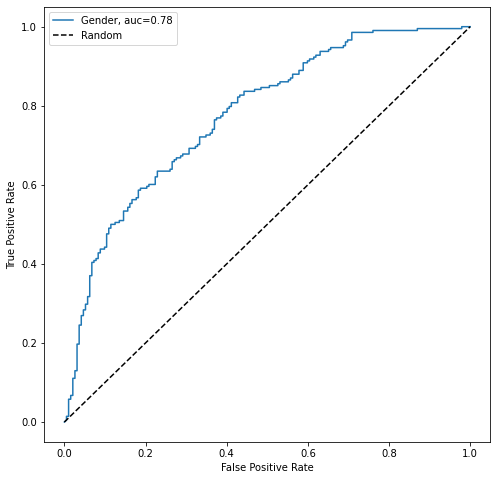

In [ ]:
# ROC curve 
plt.figure(figsize=(8,8)).clf()

fpr, tpr, thresholds = metrics.roc_curve(y_test, clf_ridge.predict_proba(X_test_pca)[:,1])
roc_auc = roc_auc_score(y_test, clf_ridge.predict_proba(X_test_pca)[:,1])
plt.plot(fpr,tpr,label="Gender, auc="+str(format(roc_auc,'.2f')))
plt.plot([0, 1], ls="--", label='Random',color='black')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='best')

**Question** What are the factors affecting the classifier performance? 


- _Dataset size_: data used to train occupation classifier was almost a third of that used for gender 
- _Class Imbalance_: Occupation data had a heavy skew whereas gender was ~50%
- _Difficulty of modeling a variable_: Try creating a classifier to predict star sign of the users! 

https://imbalanced-learn.org/stable/auto_examples/applications/plot_impact_imbalanced_classes.html#sphx-glr-auto-examples-applications-plot-impact-imbalanced-classes-py 




Few Take Home Exercises if you're interested:

1/ Which features are associated with the two genders?

2/ How does the model performance vary with the number of words per user? 

3/ Does oversampling produce different results compared to applying class_weights based on frequency?

Bonus: Here is an excellent visual illustration of the relationship between ROC and TPR/FPR: https://www.youtube.com/watch?v=4jRBRDbJemM